# BMI565 - Bioinformatics Programming & Scripting

## Week 9: Image Analysis

1. Introduction to Imaging
2. OpenCV
    * Opening Files
    * Converting between color scales
3. Clustering Image Data
    * Importing and formatting data
    * Performing clustering using scikit-learn
4. The MINST Database
5. Classification with Image Data
    * Importing data and labels for classification
    * Performing classification using SVM in scikit-learn
    * Performing classification using feedforward neural networks and convolutional neural networks in Keras
6. Summary and References

#### Requirements

1. Python 3.6
2. `opencv` module
3. `scikit-learn` module
4. `numpy` module
5. `matplotlib` module
6. `keras` module
7. Data Files
    - `./images/logo.jpg`

## Digital Images

In programming, there are many data types that we can manipulate and analyze. One of the most common of these data types is imaging data. Images are usually defined as a two-dimensional plot of intensity values. Each cell of the plot is a picture-element or "pixel". 

The method of defining a pixel varies depending on the imaging data. Black and white images can be thought of as a 2D array with values ranging from a minimum of 0, representing black, to a maximum value, representing white. The maximum value can vary based on how much fidelity is needed. Color images can be represented in a number of different ways, with three dimensions (RGB = Red, Green, Blue) or four dimensions (CMYK = cyan, magenta, yellow, black), and often include an extra value representing the luminance of the pixel. It is also possible that pixels may represent data that is not visible to the human eye, like X-ray, gamma ray, or infrared data.

## OpenCV

The OpenCV package in Python provides a number of tools to manipulate imaging data. Primarily, the tools provided are used to open and convert imaging formats so that they can be analyzed and processed. Images are stored as numpy ndarrays, which represent multidimensional arrays of fixed size.

[Documentation](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html)

OpenCV has application far beyond simply opening and viewing images:
- [Blending and sticthing images together](https://docs.opencv.org/master/d5/dc4/tutorial_adding_images.html)
- [Adjusting contrast and brightness](https://docs.opencv.org/master/d3/dc1/tutorial_basic_linear_transform.html)
- [Fourier Transform](https://docs.opencv.org/master/d8/d01/tutorial_discrete_fourier_transform.html)
- [Histogram Equalization](https://docs.opencv.org/master/d4/d1b/tutorial_histogram_equalization.html)
- [Image Segmentation](https://docs.opencv.org/master/d2/dbd/tutorial_distance_transform.html)
- [Deblurring](https://docs.opencv.org/master/de/d3c/tutorial_out_of_focus_deblur_filter.html)
- [Object Detection](https://docs.opencv.org/master/db/d28/tutorial_cascade_classifier.html)
- [and Many More!](https://docs.opencv.org/master/d9/df8/tutorial_root.html)

### Opening and Viewing Images

Our first order of business is to open an image file and inspect it. The "logo.jpg" file contains the OHSU logo in the compressed JPEG format.

In [1]:
%matplotlib inline

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn import svm, metrics
from sklearn.preprocessing import MinMaxScaler
from keras.datasets import mnist
from keras import utils
from keras import optimizers, losses
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10

Using TensorFlow backend.


In [3]:
## Read the image (1 = color, 0 = grayscale, -1 = unchanged w/ alpha channel)
img = cv2.imread('./images/logo.jpg', 4)

Inspect the img object. We can see from this that it is an array of values, most of which are [255, 255, 255]. This corresponds to a white pixel, where red, green, and blue values are all at the maximum intensity of 255. This tells us that the image is in 8-bit format, which allows for 2^8 levels of intensity (0-255).

In [4]:
## Image size
img.shape

(622, 900, 3)

In [5]:
## The image data
img[0:10,0]

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

Now that we've opened the image we can view it with `matplotlib`. 

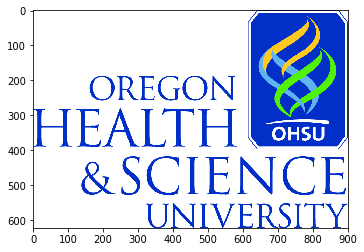

In [6]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Clustering On Imaging Data

Now that we have an image as a python data type we are free to perform any number of calculations on the image. One useful piece of information is what the most common colors in the image are. We can think about each pixel as a point in three dimensional space, where the colors red, blue, and green are mapped to spacial values. In this spacial context, we can use clustering to find the areas in the space of colors where most pixels are located.

The first thing we need to do is to convert our image from a two-dimensional array into a one-dimensional list of pixels. For this analysis, we are only interested in the color data and not in the location of each pixel within the image.

Reshape and shape are methods of the ndarray class. Shape gives the dimensions of an n-dimensional array as a tuple with n positions. Reshape takes a tuple with n positions and reorganizes the array to fit that specification.

Here we take the first two dimensions of the array (representing the 2d location information) and flatten it into a column of values where each row contains a single pixel's color intensity information.

In [7]:
## Reshape the image to be a list of pixels
img = img.reshape((img.shape[0] * img.shape[1], 3))

In [8]:
img.shape

(559800, 3)

In [9]:
img[0:5]

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

We are now ready to import the KMeans method from scikit-learn. We define that we want a model with 5 clusters. This will return the five "neighborhoods" where most pixel values are centered. Theoretically this should fit our image well, since there are exactly five colors in the image.

In [10]:
## Do clustering
clt = KMeans(n_clusters = 5)
clt.fit(img)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [11]:
## View the cluster centers
clt.cluster_centers_

array([[254.89787952, 254.76324373, 254.72873724],
       [199.24570551,  48.60009653,   3.05789544],
       [  9.35204856, 238.80918058,  79.77314112],
       [234.15948827, 168.33610519, 122.88663824],
       [ 33.97302129, 200.30407931, 251.9512433 ]])

We will now define a function that will help us analyze and display the data. It will create a histogram that represents the number of pixels associated with each cluster center. The function uses numpy (imported above).

In [12]:
def centroid_histogram(clt):
    ## grab the number of different clusters and create a histogram
    ## based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
 
    ## normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
 
    ## return the histogram
    return hist

## build a histogram of clusters and then create a figure
## representing the number of pixels labeled to each color
hist = centroid_histogram(clt)

Let's display our color plot of the OHSU logo image.

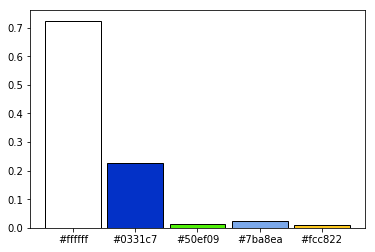

In [13]:
## We can also create a bar plot to represent the same info
## Convert the colors from GBR to RGB and scale the values
colors = [c[::-1]/255 for c in clt.cluster_centers_]
plt.bar(np.arange(1,6), hist, width=0.9, color=colors, edgecolor='black')

## Create x-axis ticks and labels (converting RGB colors to hexadecimal)
ticks1 = plt.xticks(np.arange(1,6), [mpl.colors.rgb2hex(x) for x in colors])

The resulting plots capture the five major colors used in the image and their relative frequencies. As we can see, the image is mostly white and blue with a sprinkling of other colors mixed in. If we wish to know the exact proportions it is possible to use the histogram object in order to find these.

## The MNIST Database

While clustering is a useful way of describing data, it is not always the best tool for classification. In cases where we have labeled data, a supervised learning method is often preferable. One canonical example is the recognition of digits from handwriting. 

The [Modified National Institute of Standards and Technology](http://yann.lecun.com/exdb/mnist/) (MNIST) database is a large database of handwritten digits that is commonly used for training various image processing systems. It is also widely used for training and testing in the field of machine learning, and contains 60,000 training images and 10,000 testing images.

[Wikipedia](https://en.wikipedia.org/wiki/MNIST_database)

Load the pre-shuffled MNIST data into train and test sets

In [14]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Let's just take a brief look at how the labels are formatted, and at an example of one of the hand-written digits

In [15]:
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]


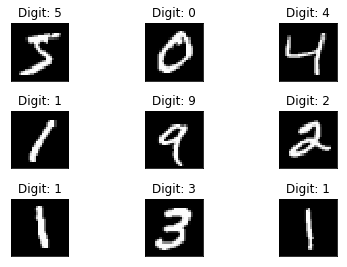

In [16]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

In [17]:
## The image size
x_train[0].shape

(28, 28)

In [18]:
## This tells us we have 60,000 images of handwritten digits of size 28x28 pixels
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Now, just to save on compute time, let's reduce the size of our training dataset down to the size of our test dataset.

**A WORD OF CAUTION:** What we save in training time, we may lose in model accuracy!

In [19]:
x_train = x_train[:10000, :]
y_train = y_train[:10000]
print(x_train.shape)
print(y_train.shape)

(10000, 28, 28)
(10000,)


In [20]:
## Examine pixel intensity range
print(x_train[0].min())
print(x_train[0].max())

0
255


The images have pixel values that range from 0 to 255. This can be problematic for machine learning algorithms (i.e., exploding gradients). An error gradient is the direction and magnitude calculated during the training of a neural network that is used to update the network weights in the right direction and by the right amount.

In deep networks neural networks, error gradients can accumulate during an update and result in very large gradients. These result in large updates to the network weights and, in turn, an unstable network. At an extreme, the values of weights can become so large (lim -> $\infty$) as to overflow and result in NaN values.

The explosion occurs through exponential growth by repeatedly multiplying gradients through the network layers that have values larger than 1.0. So, prior to performing machine learning tasks on these images, we should normalize them. There are three common ways to do this:

- (x - x.min()) / (x.max() - x.min())
    - Values will range from 0 to 1
- 2*(x - x.min()) / (x.max() - x.min()) - 1
    - Values will range from -1 to 1
- (x - x.mean()) / x.std()
    - Value range is unknown, but data will be centered at 0 (mean)

In [21]:
## To scale an entire matrix, we'll create a simple function and call it on the train and test datasets
def rescale_data(matrix):
    scaled = (matrix - matrix.min()) / (matrix.max() - matrix.min())
    return(scaled)

x_train = rescale_data(x_train)
x_test = rescale_data(x_test)

print(x_train[0].min(), x_train[0].max())
print(x_test[0].min(), x_test[0].max())

0.0 1.0
0.0 1.0


We are also going to convert our training and test labels to [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). This is essentially a process that converts a single multi-class categorical variable/column into multiple binary variables/columns, and is necessary for some machine learning models.

In [22]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
onehot_train = utils.to_categorical(y_train, 10)
onehot_test = utils.to_categorical(y_test, 10)
print(onehot_train.shape)
print(y_train[0])
print(onehot_train[0])

(10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Classification of Handwritten Digits

###  Classification of Images Using an SVM

Reminder: A support-vector machine (SVM) is a method for classifying data by identifying a hyperplane which divides the data into two classes. The hyperplane is selected to maximize the margin between the separating boundary and the training data.

[Wikipedia](http://en.wikipedia.org/wiki/Support_vector_machine)

[scikit-learn Documentation](http://scikit-learn.org/stable/modules/svm.html#svm)

In cases where data may not be separable with a straight line, we can transform the dataset using 'kernels'. Essentially, we perform a function on each value (e.g. squaring the value, dividing by pi, etc.) so that the data aggregates in such a way that a straight line can separate it.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Kernel_Machine.svg/2560px-Kernel_Machine.svg.png width=800>

In order for us to analyze the images using this algorithm, we must first restructure the data so that they exist as single rows. Each column will represent a specific pixel's intensity value. 

Since we know `x_train` contains 60,000 images of 28 x 28 pixel images, we know that the final matrix shape must be 60,000 x 784 (28x28). Similarly, for `x_test`, the final shape must be 10,000 x 784.

In [23]:
x_train_flattened = np.reshape(x_train, (10000, 784))
x_test_flattened = np.reshape(x_test, (10000, 784))
print(x_train_flattened.shape)
print(x_test_flattened.shape)

(10000, 784)
(10000, 784)


We're now ready to move on to fitting our model. We use a support vector machine (SVM) which considers each pixel intensity value in the digit as a dimension in euclidian space. The SVM then attempts to draw an optimized boundary between points of different classes in order to classify them into groups. Since we have 10 classes (numbers 0-9) it will divide them into ten categories.

We also load the metrics method, which contains reports that work with scikit-learn's classifiers in order to provide information about the performance of the classifier. Here we use the `classification_report` and `confusion_matrix` methods.

In [24]:
## Train an SVM classifier
svm_model = svm.LinearSVC()
svm_model.fit(x_train_flattened, y_train)

## Predict the classes of the test set
svm_predicted = svm_model.predict(x_test_flattened)
print("Classification report for the %s:\n\n%s\n"
      % (svm_model, metrics.classification_report(y_test, svm_predicted)))

Classification report for the LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0):

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.90      0.85      0.87      1032
           3       0.86      0.88      0.87      1010
           4       0.90      0.90      0.90       982
           5       0.85      0.84      0.84       892
           6       0.91      0.93      0.92       958
           7       0.90      0.90      0.90      1028
           8       0.81      0.82      0.82       974
           9       0.87      0.84      0.85      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89 

/anaconda2/envs/python3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [25]:
## View a confusion matrix of the classification results
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, svm_predicted))

Confusion matrix:
[[ 937    0    7    3    1   10   12    3    4    3]
 [   2 1096    4    2    1    4    5    0   20    1]
 [   7   17  875   28    9    9   16   14   54    3]
 [   5    1   23  887    4   38    6   14   23    9]
 [   3    4    9    4  882    2   11    9   13   45]
 [  14    2    5   50    5  747   16    8   39    6]
 [  13    3   11    1    9   21  891    1    8    0]
 [   0    7   27    6    7    5    1  928    7   40]
 [  10   19   11   30   15   37   15   10  803   24]
 [  10   10    3   19   51   10    2   43   16  845]]


From this we can see that our classifier worked decently, but not great. We get good precision, showing that our method does a decent job of minimizing false positives. We can also see that our recall is relatively high, meaning that it calls fairly few false negatives. From our graph it seems the numerals 3, 8, and 9 are the hardest to predict, while 0, 1, and 6 are the easiest.

### Classification of Images Using Feedforward Neural Networks

A feedforward neural network is an artificial neural network wherein connections between the nodes do not form a cycle. The feedforward neural network was the first and simplest type of artificial neural network devised. In this network, the information moves forward, from the input nodes, through the hidden nodes (if any), to the output nodes.

[Wikipedia](https://en.wikipedia.org/wiki/Feedforward_neural_network)

[Keras Documentation](https://keras.io/)

![](https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif)

Let's build our neural network model. We start by instantiating a squential model that will accept and input of the same shape as our training data and feed that into a hidden layer containing 128 nodes – this number was chosen arbitrarily. Before feeding this information to our final layer, we add a regularization technique called `Dropout`, which essentially sets some of the learned weights to 0 during the training process to prevent our model from over fitting. The final layer containing 10 nodes, each representing a possible outcome variable (i.e., numbers 0 through 9).

In [26]:
nn_model = Sequential()
nn_model.add(Dense(units=128, activation='relu', input_shape=x_train_flattened.shape[1:]))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(units=10, activation='softmax'))

nn_model.compile(
    loss = losses.categorical_crossentropy,
    optimizer = optimizers.SGD(lr = 0.1),
    metrics = ['accuracy'])

nn_model.summary()

W0918 12:47:58.629409 140735775355776 deprecation_wrapper.py:119] From /anaconda2/envs/python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0918 12:47:58.661000 140735775355776 deprecation_wrapper.py:119] From /anaconda2/envs/python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0918 12:47:58.747293 140735775355776 deprecation_wrapper.py:119] From /anaconda2/envs/python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0918 12:47:58.760288 140735775355776 deprecation_wrapper.py:119] From /anaconda2/envs/python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.place

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [27]:
nn_model.fit(x_train_flattened, onehot_train, epochs = 5, batch_size = 32, validation_split = 0.25)

W0918 12:47:58.925339 140735775355776 deprecation.py:323] From /anaconda2/envs/python3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7500 samples, validate on 2500 samples
Epoch 1/5
7500/7500 [==============================] - 2s 223us/step - loss: 0.8157 - acc: 0.7497 - val_loss: 0.4286 - val_acc: 0.8812
Epoch 2/5
7500/7500 [==============================] - 1s 133us/step - loss: 0.4365 - acc: 0.8700 - val_loss: 0.3486 - val_acc: 0.9028
Epoch 3/5
7500/7500 [==============================] - 1s 136us/step - loss: 0.3636 - acc: 0.8917 - val_loss: 0.3329 - val_acc: 0.8988
Epoch 4/5
7500/7500 [==============================] - 1s 133us/step - loss: 0.3147 - acc: 0.9089 - val_loss: 0.2887 - val_acc: 0.9128
Epoch 5/5
7500/7500 [==============================] - 1s 132us/step - loss: 0.2743 - acc: 0.9189 - val_loss: 0.2785 - val_acc: 0.9152


In [28]:
score = nn_model.evaluate(x_test_flattened, onehot_test)
print('Loss:', score[0])
print('Accuracy:', score[1])

10000/10000 [==============================] - 0s 28us/step
Loss: 0.2520422165513039
Accuracy: 0.9224


In [29]:
nn_predicted = nn_model.predict(x_test_flattened)
nn_predicted = [np.argmax(x) for x in nn_predicted]

print("Classification report for the %s:\n\n%s\n"
      % ('Feedforward Neural Network', metrics.classification_report(y_test, nn_predicted)))

Classification report for the Feedforward Neural Network:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.90      0.94      0.92      1010
           4       0.90      0.94      0.92       982
           5       0.94      0.88      0.91       892
           6       0.94      0.94      0.94       958
           7       0.84      0.95      0.90      1028
           8       0.93      0.87      0.90       974
           9       0.94      0.82      0.88      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000




In [30]:
## View a confusion matrix of the classification results
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, nn_predicted))

Confusion matrix:
[[ 958    0    1    3    0    3    9    3    3    0]
 [   0 1117    4    3    1    0    3    2    5    0]
 [   9    6  932   16   14    1    7   26   20    1]
 [   1    0   15  947    2   13    1   16   12    3]
 [   1    3    4    0  925    0    9    8    4   28]
 [   8    2    4   37    6  786   16   11   15    7]
 [  12    3    6    1   20   11  901    1    3    0]
 [   0   10   24    2    5    1    0  981    1    4]
 [   6    9   12   30    8   15   10   28  846   10]
 [   8    7    2   17   48    5    2   86    3  831]]


As compared to the SVM, we can see that this classifier works much better. Mainly, precision and recall are much higher across the board. But we still struggle with some digits.

### Classification of Images Using Convolutional Neural Networks

Convolutional neural networks (CNN, or ConvNet) are a class of deep neural networks, most commonly applied to analyzing visual imagery. They show remarkable prowess in image classificaiton and segmentation.

[Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)

[Keras Documentation](https://keras.io/)

![](https://cdn-images-1.medium.com/max/2400/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

So, how does this model differ from a feedforward neural network? Well, rather than learning which pixels are illuminated for specific numbers, a CNN develops filters to describe the shapes it sees, then feeds those findings into a feedforward neural network.

![](https://miro.medium.com/max/2510/1*2SWb6CmxzbPZijmevFbe-g.jpeg)

The image above illustrates this process. First, filters are passed over the image of a car. These filters are pulling out features which may be predictive of the image class. Then, filters are passed over these newly-create images, and so on. The final, highly-abstract images can then be thought of as a feature map - a matrix that tells the neural network which features were activated after looking at an image and which were not. This matrix is then flattened into a single row, and few into a feedforward neural network.

This proves useful on the MNIST database, but really shines when we look at images of everyday objects.

As before, our first task is to open the file and get the image into a format that makes sense for our purposes. For convolutional neural networks, in addition to specifying how many images we have, and their height/width, we also need to specify how many channels the images have.

Grayscale images, which are what we have, have a single channel. Color images have three channels, red, green, and blue. Some images have a fourth channel for an alpha layer, which simply adds transparency. There are also satellite and medical images, which can have tens, hundreds, or thousands of channels/layers. Since our images are grayscale, we need to reshape `x_train` and `x_test` to have a fourth dimension with value equal to 1. Additionally, a convolutional neural network expects to receive at least a 2D structure (i.e. a matrix), so we will be using the original train/test data and not the flattened data.

In [31]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train[:10000]
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
print(x_train.shape)
print(x_test.shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)


In [32]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(units=10, activation='softmax'))

cnn_model.compile(
    loss = losses.categorical_crossentropy,
    optimizer = optimizers.SGD(lr=0.1),
    metrics = ['accuracy'])

cnn_model.summary()

W0918 12:48:05.401510 140735775355776 deprecation_wrapper.py:119] From /anaconda2/envs/python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               692352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


In [33]:
cnn_model.fit(x_train, onehot_train, epochs = 5, batch_size = 32, validation_split = 0.25)

Train on 7500 samples, validate on 2500 samples
Epoch 1/5
7500/7500 [==============================] - 5s 654us/step - loss: 0.7615 - acc: 0.7525 - val_loss: 0.3897 - val_acc: 0.8948
Epoch 2/5
7500/7500 [==============================] - 4s 541us/step - loss: 0.3871 - acc: 0.8849 - val_loss: 0.3343 - val_acc: 0.8992
Epoch 3/5
7500/7500 [==============================] - 4s 534us/step - loss: 0.2957 - acc: 0.9101 - val_loss: 0.2344 - val_acc: 0.9304
Epoch 4/5
7500/7500 [==============================] - 4s 524us/step - loss: 0.2474 - acc: 0.9276 - val_loss: 0.2280 - val_acc: 0.9292
Epoch 5/5
7500/7500 [==============================] - 4s 525us/step - loss: 0.1994 - acc: 0.9417 - val_loss: 0.2032 - val_acc: 0.9396


In [34]:
cnn_score = cnn_model.evaluate(x_test, onehot_test)
print('Loss:', cnn_score[0])
print('Accuracy:', cnn_score[1])

10000/10000 [==============================] - 2s 178us/step
Loss: 0.1756557979941368
Accuracy: 0.9455


In [35]:
cnn_predicted = cnn_model.predict(x_test)
cnn_predicted = [np.argmax(x) for x in cnn_predicted]

print("Classification report for the %s:\n\n%s\n"
      % ('Convolutional Neural Network', metrics.classification_report(y_test, cnn_predicted)))

Classification report for the Convolutional Neural Network:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.94      0.94      1032
           3       0.97      0.92      0.95      1010
           4       0.90      0.98      0.93       982
           5       0.94      0.95      0.94       892
           6       0.94      0.97      0.95       958
           7       0.98      0.92      0.95      1028
           8       0.93      0.92      0.92       974
           9       0.94      0.89      0.91      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.94     10000
weighted avg       0.95      0.95      0.95     10000




In [36]:
## View a confusion matrix of the classification results
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, cnn_predicted))

Confusion matrix:
[[ 969    0    0    0    0    2    5    0    3    1]
 [   0 1122    2    1    1    0    4    0    4    1]
 [  11    4  965    6    7    1   14    4   18    2]
 [   0    2   15  932    1   27    2    9   17    5]
 [   2    1    1    0  958    0   11    0    3    6]
 [   9    2    0    5    5  848   11    1    7    4]
 [  10    3    0    1    8    7  927    0    2    0]
 [   3   10   32    2    8    1    0  946    2   24]
 [  12    4    5    7   13   13   12    4  893   11]
 [   9    7    1    7   69    6    1    6    8  895]]


## Summary

Let's see how our final models performed compared to one another:

In [37]:
print("Classification report for the %s:\n\n%s\n"
      % ('Support Vector Machine', metrics.classification_report(y_test, svm_predicted)))

print("Classification report for the %s:\n\n%s\n"
      % ('Feedforward Neural Network', metrics.classification_report(y_test, nn_predicted)))

print("Classification report for the %s:\n\n%s\n"
      % ('Convolutional Neural Network', metrics.classification_report(y_test, cnn_predicted)))

Classification report for the Support Vector Machine:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.90      0.85      0.87      1032
           3       0.86      0.88      0.87      1010
           4       0.90      0.90      0.90       982
           5       0.85      0.84      0.84       892
           6       0.91      0.93      0.92       958
           7       0.90      0.90      0.90      1028
           8       0.81      0.82      0.82       974
           9       0.87      0.84      0.85      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Classification report for the Feedforward Neural Network:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1     

By now, you have learned a few specific ways in which imaging data can be manipulated for viewing or to draw interesting conclusions. Furthermore, I hope you have learned some interesting ways in which machine learning methods can be applied to imaging data for classification.

But it doesn't stop here. The field of imaging is much larger than presented here, however, and python has many packages that perform various imaging tasks. Some common tasks include image enhancement, image filtering, and image segmentation (the isolation of various features of interest based on their attributes). While the packages necessary to do such manipulations may be different, the underlying workflow remains essentially the same – reading the image data, reformatting the image data, and using that data in order to find the features of interest using various methods.

## In-class Exercises

For this task, we'll use the CIFAR-10 dataset, which contains 60,000 32x32 color images from 10 classes. This dataset contains images of airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks – labeled 0 through 9, respectively.

Can you build a multi-class classifier that identifies each type of image?

I'll help you load it, but the rest is up to you...

In [38]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

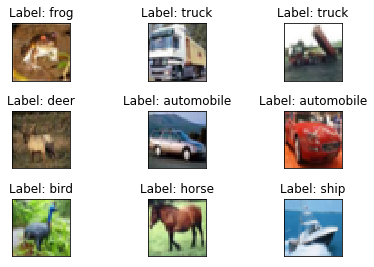

In [39]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(labels[y_train[i][0]]))
  plt.xticks([])
  plt.yticks([])

In [40]:
## Note that the data is already in the proper format, so it does not need to be reshaped
## Other data preprocessing steps may still apply...
x_train.shape

(50000, 32, 32, 3)

In [41]:
## Begin coding here

## References

- [OpenCV Tutorial](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html)
- [Image Clustering Tutorial](http://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/)
- [OpenCV Digit Classification Tutorial](http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_ml/py_knn/py_knn_opencv/py_knn_opencv.html)
- [Keras Tutorial](https://keras.io/)

#### Last Updated: 18-Sep-2019